## Building and training a CNN model

In [1]:
import sys
import os
import glob
import yaml
import typing
import numpy as np
import pandas as pd
import sklearn.metrics
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

# hint: notebook is executed in jupyter lab dark mode
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# see https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html for styles
# plt.style.use('dark_background')
# # global color settings (use white/grey for jupyterlab dark mode
# # and black/grey for jupyterlab light mode)
# COLOR = 'grey'
# plt.rcParams['text.color'] = COLOR
# plt.rcParams['axes.labelcolor'] = COLOR
# plt.rcParams['xtick.color'] = COLOR
# plt.rcParams['ytick.color'] = COLOR
# # plt.rcParams['grid.color'] = COLOR
# # plt.rcParams['figure.edgecolor'] = 'red'
plt.rcParams['figure.figsize'] = (12, 6)

print(f'Python version: {sys.version}')
print(f'Numpy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')
print(f'sklearn version: {sklearn.__version__}')
print(f'Tensorflow version: {tf.__version__}')
print(f'Keras version: {keras.__version__}')
print(f"Available gpu devices: {tf.config.list_physical_devices('GPU')}")

## the following code snippet is necessary for tensorflow 
## training to work (tf2.2, cuda10.2 or 10.1)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for physical_device in physical_devices: 
    tf.config.experimental.set_memory_growth(physical_device, True)

Python version: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
Numpy version: 1.19.1
Pandas version: 1.1.3
sklearn version: 0.23.2
Tensorflow version: 2.2.0
Keras version: 2.4.3
Available gpu devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
## model name:
MODEL_NAME = 'model_densenet121_2'

## create figure path if it does not exist
PATH_FIGURES = f'figs/models/{MODEL_NAME}/'
os.makedirs(PATH_FIGURES, exist_ok=True)

## location to save the models
PATH_MODEL = f'models/{MODEL_NAME}/'
os.makedirs(PATH_MODEL, exist_ok=True)

## random number generator seed:
RANDOM_STATE = 5

## use one of 'vgg16', 'resnet50', 'densenet121':
MODEL_BASE_ARCHITECTURE='densenet121'
INITIAL_LEARNING_RATE = 0.001
EPOCHS = 50
## image training parameters:
## use (224, 224, 3) for vgg16 model
## use (224, 224, 3) for resnet50 model
IMG_SIZE = (224, 224)
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_VALID = 16
BATCH_SIZE_TEST = 16
TRAIN_SIZE = 0.8
VALIDATION_SIZE = 0.1
TEST_SIZE = 0.1
BALANCE_TRAINING_DATA = True
VALID_TEST_REBALANCE_RATIO = 0.25
## in early stopping: how many epochs may the validation loss
## function not improve until we stop training
EARLY_STOPPING_PATIENCE = 16

DICT_AUGMENTATION = {
    'zca_whitening': False,
    'horizontal_flip': True, 
    'vertical_flip': False,
    'height_shift_range': 0.1,
    'width_shift_range': 0.1,
    'rotation_range': 10,
    'shear_range': 0.1,
    'zoom_range': 0.15,
}

## Data import and preprocessing:

In [3]:
## get data
df = pd.read_hdf('data_summary.hdf')
## convert class labels to string:
df['class_pneumonia'] = df['label_pneumonia'].astype('str')
df.head()

iid          finding_labels  nr_follow_up  pid  patient_age  \
0  00000001_000.png            cardiomegaly             0    1           58   
1  00000001_001.png  cardiomegaly|emphysema             1    1           58   
2  00000001_002.png   cardiomegaly|effusion             2    1           58   
3  00000002_000.png              no_finding             0    2           81   
4  00000003_000.png                  hernia             0    3           81   

  patient_gender view_position  oimage_width  oimage_height  \
0              m            pa          2682           2749   
1              m            pa          2894           2729   
2              m            pa          2500           2048   
3              m            pa          2500           2048   
4              f            pa          2582           2991   

   oimage_px_spacing_x  ...  label_fibrosis label_hernia  label_infiltration  \
0                0.143  ...               0            0                   0   
1                0.143  ...               0            0                   0   
2                0.168  ...               0            0                   0   
3                0.171  ...               0            0                   0   
4                0.143  ...               0            1                   0   

   label_mass  label_no_finding  label_nodule  label_pleural_thickening  \
0           0                 0             0                         0   
1           0                 0             0                         0   
2           0                 0             0                         0   
3           0                 1             0                         0   
4           0                 0             0                         0   

   label_pneumonia  label_pneumothorax  class_pneumonia  
0                0                   0                0  
1                0                   0                0  
2                0                   0                0  
3                0                   0                0  
4                0                   0                0  

[5 rows x 28 columns]

## Training, validation and testing data

In [4]:
def create_splits(df, train_size: float=0.8, valid_size: float=0.1, test_size: float=0.1,
                  random_state: typing.Union[None, int]=None) -> typing.List[pd.DataFrame]:
    """
    Split dataset into training, validation and testing set. The split is done on patient level
    so that a specific patient can only be in one of the datasets.
    :param df: dataframe containing all samples
    :param train_size: relative size of training dataset
    :param valid_size: relative size of validation dataset
    :param test_size: relative size of testing dataset
    :param random_state: numpy random number sampling seed
    :return: list of 3 pandas data frames: training df, validation df, testing df
    """
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    if 'pid' not in df:
        raise AttributeError("Feature 'pid' not available in df.")
    if 'label_pneumonia' not in df:
        raise AttributeError("Feature 'label_pneumonia' not available in df.")
    
    np.random.seed(seed=random_state)
    ## select all patients from the total dataset in random order
    pid_rand = np.random.choice(df['pid'].unique(), size=df['pid'].nunique(),
                                replace=False, p=None)
    pids_train = pid_rand[: int(df['pid'].nunique() * train_size)]
    pids_valid = pid_rand[
        int(df['pid'].nunique() * train_size): int(df['pid'].nunique() * (train_size + valid_size))
    ]
    pids_test = pid_rand[int(df['pid'].nunique() * (train_size + valid_size)):]
    ## get training dataset:
    df_train = df[df['pid'].isin(pids_train)]
    ## get validation dataset
    df_valid = df[df['pid'].isin(pids_valid)]
    ## get test dataset
    df_test = df[df['pid'].isin(pids_test)]
    return df_train, df_valid, df_test


def rebalance_binary_class_dataset(
    df: pd.DataFrame,
    col_label: str,
    ratio_pn: float=1.0,
    random_state: typing.Union[None, int]=None
) -> pd.DataFrame:
    """
    Rebalance dataset so that it has some number of labels. The label with the lowest
    frequency is the reference value.
    :param df: dataframe which should be balanced
    :param col_label: column containing the labels
    :param ratio_pn: Ratio between positive (p) and negative (n) samples (p/n)
    :param random_state: numpy random number seed
    :return: balanced dataframe
    """
    ## create a balanced training dataset by randomly selecting 
    ## negative samples and discarding the remaining:
    
    ## get class cardinalities:
    ser_vcounts = df['label_pneumonia'].value_counts()
    
    nr_pos = ser_vcounts[1]
    if ratio_pn<1:
        nr_neg = ser_vcounts[0] / ratio_pn
    else:
        nr_neg = ser_vcounts[1] / ratio_pn
    while nr_neg>ser_vcounts[0]:
        nr_pos -= 1
        nr_neg = nr_pos / ratio_pn

    # only approximately close because of numerical uncertenties:
    np.testing.assert_allclose(
        actual=nr_pos/nr_neg,
        desired=ratio_pn,
        rtol=1e-07,
        atol=0,
        equal_nan=True,
        err_msg='',
        verbose=True
    )
    
    df1 = df[df[col_label]==0].sample(int(nr_neg), random_state=random_state)
    df1 = df1.append(df[df[col_label]==1].sample(int(nr_pos), random_state=random_state))
    return df1.sample(frac=1)


def data_split_analysis(df: pd.DataFrame, df_train: pd.DataFrame, df_valid: pd.DataFrame,
                        df_test: pd.DataFrame, df_train_sample: pd.DataFrame) -> pd.DataFrame:
    """
    Generate a DataFrame that contains information about a dataframe and its split.
    By examining the output information dataframe one can get a quick overfiew of split parameters
    and if the splitted dataframes represent the overall demographics.
    :param df: original DataFrame which was split into training, validation and testing sets
    :param df_train: training dataset
    :param df_valid: validation dataset
    :param df_test: testing dataset
    :param df_train_sample: smaller sample of the training dataset
    :return: dataframe containing information about the dataset splits
    """
    df1 = pd.DataFrame(columns=['train', 'valid', 'test', 'train_sample', 'complete_dataset'])

    df1.loc['nr_patients'] = [
        df_train['pid'].nunique(), df_valid['pid'].nunique(), df_test['pid'].nunique(),
        df_train_sample['pid'].nunique(), df['pid'].nunique()
    ]
    df1.loc['cardinality'] = [
        df_train.shape[0], df_valid.shape[0], df_test.shape[0],
        df_train_sample.shape[0], df.shape[0]
    ]
    df1.loc['relative_cardinality'] = df1.loc['cardinality'] / df.shape[0]

    df1.loc['positive_samples'] = [
        df_train['label_pneumonia'].sum(), df_valid['label_pneumonia'].sum(),
        df_test['label_pneumonia'].sum(), df_train_sample['label_pneumonia'].sum(),
        df['label_pneumonia'].sum()
    ]
    df1.loc['negative_samples'] = df1.loc['cardinality'] - df1.loc['positive_samples']
    
    df1.loc['ratio_pos_neg_samples'] = (
        df1.loc['positive_samples'] / df1.loc['negative_samples']
    )

    df1.loc['age_mean'] = [
        df_train['patient_age'].mean(), df_valid['patient_age'].mean(),
        df_test['patient_age'].mean(), df_train_sample['patient_age'].mean(),
        df['patient_age'].mean()
    ]
    df1.loc['age_std'] = [
        df_train['patient_age'].std(), df_valid['patient_age'].std(),
        df_test['patient_age'].std(), df_train_sample['patient_age'].std(), 
        df['patient_age'].std()
    ]

    df1.loc['age_mean_positive_samples'] = [
        df_train.loc[df_train['label_pneumonia']==1, 'patient_age'].mean(),
        df_valid.loc[df_valid['label_pneumonia']==1, 'patient_age'].mean(),
        df_test.loc[df_test['label_pneumonia']==1, 'patient_age'].mean(),
        df_train_sample.loc[df_train_sample['label_pneumonia']==1, 'patient_age'].mean(),
        df.loc[df['label_pneumonia']==1, 'patient_age'].mean()
    ]
    df1.loc['age_std_positive_samples'] = [
        df_train.loc[df_train['label_pneumonia']==1, 'patient_age'].std(),
        df_valid.loc[df_valid['label_pneumonia']==1, 'patient_age'].std(),
        df_test.loc[df_test['label_pneumonia']==1, 'patient_age'].std(),
        df_train_sample.loc[df_train_sample['label_pneumonia']==1, 'patient_age'].std(),
        df.loc[df['label_pneumonia']==1, 'patient_age'].std()
    ]

    df1.loc['age_mean_negative_samples'] = [
        df_train.loc[df_train['label_pneumonia']==0, 'patient_age'].mean(),
        df_valid.loc[df_valid['label_pneumonia']==0, 'patient_age'].mean(),
        df_test.loc[df_test['label_pneumonia']==0, 'patient_age'].mean(),
        df_train_sample.loc[df_train_sample['label_pneumonia']==0, 'patient_age'].mean(),
        df.loc[df['label_pneumonia']==0, 'patient_age'].mean()
    ]
    df1.loc['age_std_negative_samples'] = [
        df_train.loc[df_train['label_pneumonia']==0, 'patient_age'].std(),
        df_valid.loc[df_valid['label_pneumonia']==0, 'patient_age'].std(),
        df_test.loc[df_test['label_pneumonia']==0, 'patient_age'].std(),
        df_train_sample.loc[df_train_sample['label_pneumonia']==0, 'patient_age'].std(),
        df.loc[df['label_pneumonia']==0, 'patient_age'].std()
    ]

    df1.loc['females'] = [
        (df_train['patient_gender']=='f').sum(), (df_valid['patient_gender']=='f').sum(),
        (df_test['patient_gender']=='f').sum(), (df_train_sample['patient_gender']=='f').sum(),
        (df['patient_gender']=='f').sum()
    ]
    df1.loc['females_relative'] = df1.loc['females'] / df1.loc['cardinality']

    df1.loc['males'] = [
        (df_train['patient_gender']=='m').sum(), (df_valid['patient_gender']=='m').sum(),
        (df_test['patient_gender']=='m').sum(), (df_train_sample['patient_gender']=='m').sum(),
        (df['patient_gender']=='m').sum()
    ]
    df1.loc['males_relative'] = df1.loc['males'] / df1.loc['cardinality']

    df1.loc['pa_position'] = [
        (df_train['view_position']=='pa').sum(), (df_valid['view_position']=='pa').sum(),
        (df_test['view_position']=='pa').sum(), (df_train_sample['view_position']=='pa').sum(),
        (df['view_position']=='pa').sum()
    ]
    df1.loc['pa_position_relative'] = df1.loc['pa_position'] / df1.loc['cardinality']

    df1.loc['ap_position'] = [
        (df_train['view_position']=='ap').sum(), (df_valid['view_position']=='ap').sum(),
        (df_test['view_position']=='ap').sum(), (df_train_sample['view_position']=='ap').sum(),
        (df['view_position']=='ap').sum()
    ]
    df1.loc['ap_position_relative'] = df1.loc['ap_position'] / df1.loc['cardinality']
    return df1


def get_classes(predictions: np.array, thresh: float=0.5) -> np.array:
    """
    
    """
    classes = predictions.copy()
    classes[classes>=thresh] = 1
    classes[classes<thresh] = 0
    return classes


def evaluation_metrics(y_true, y_pred, y_pred_proba):
    """
    
    """
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
        y_true=y_true, y_pred=y_pred, labels=None,
        sample_weight=None, normalize=None
    ).ravel()
    balanced_accuracy = sklearn.metrics.balanced_accuracy_score(
        y_true=y_true, y_pred=y_pred,
        sample_weight=None, adjusted=False
    )
    f1 = sklearn.metrics.f1_score(
        y_true=y_true, y_pred=y_pred,
        labels=None, pos_label=1, average='binary',
        sample_weight=None, zero_division='warn'
    )
    recall = sklearn.metrics.recall_score(
        y_true=y_true, y_pred=y_pred, labels=None, pos_label=1,
        average='binary', sample_weight=None, zero_division='warn'
    )
    precision = sklearn.metrics.precision_score(
        y_true=y_true, y_pred=y_pred, labels=None, pos_label=1,
        average='binary', sample_weight=None, zero_division='warn'
    )
    auc = sklearn.metrics.roc_auc_score(
        y_true=y_true, y_score=y_pred_proba, average='macro',
        sample_weight=None, max_fpr=None, multi_class='raise', labels=None
    )
    
    dict_evals = {}
    dict_evals['tp'] = tp
    dict_evals['tn'] = tn
    dict_evals['fn'] = fn
    dict_evals['fp'] = fp
    dict_evals['f1'] = f1
    dict_evals['precision'] = precision
    dict_evals['recall'] = recall
    dict_evals['balanced_accuracy'] = balanced_accuracy
    dict_evals['auc'] = auc
    return dict_evals


def plot_confusion_matrix(tp, tn, fp, fn):
    """
    
    """
    df_cm = pd.DataFrame([[tn,fp], [fn, tp]], index=range(2), columns=range(2))
    sns.set(font_scale=1.4) # for label size
    ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt="d") # font size
    _ = ax.set(xlabel='predictions', ylabel='labels', title='Confusion matrix')
    return ax


def plot_precision_recall_curve(y_true, y_pred_proba):
    """
    
    """
    precisions, recalls, thresholds = sklearn.metrics.precision_recall_curve(
        y_true=y_true, probas_pred=y_pred_proba,
        pos_label=True, sample_weight=None
    )

    fig, ax = plt.subplots()
    lw = 2
    ax.plot(recalls, precisions, color='darkorange',
            lw=lw, label='Precision-recall curve')
    # ax.set_xlim([0.0, 1.0])
    # ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision-recall curve')
    # ax.legend(loc="lower right")
    fig.tight_layout()
    return ax


def plot_auc(y_true, y_pred_proba):
    """
    
    """
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = sklearn.metrics.roc_curve(y_true=y_true, y_score=y_pred_proba)
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    # test_gen.reset
    # # Compute micro-average ROC curve and ROC area
    # fpr_micro, tpr_micro, _ = sklearn.metrics.roc_curve(y_true=labels, y_score=predictions)
    # roc_auc_micro = sklearn.metrics.auc(fpr_micro, tpr_micro)

    fig, ax = plt.subplots()
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(loc="lower right")
    fig.tight_layout()
    return ax, fpr, tpr


def plot_history(history):
    """
    plotting the history of model training
    """
    N = len(history.history['loss'])
    fig, ax = plt.subplots()
    ax.plot(np.arange(0, N), history.history['loss'], label='train_loss')
    ax.plot(np.arange(0, N), history.history['val_loss'], label='val_loss')
#     plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
#     plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    ax.set_title('Training and Validation Loss on Dataset')
    ax.set_xlabel('Epoch #')
    ax.set_ylabel('Loss')
    ax.legend(loc='lower left')
    fig.tight_layout()
    return ax


def preprocessing_image_data_generator(model_architecture='vgg16', **kwargs_augmentation) -> ImageDataGenerator:
    """
    Depending on the chosen (pretrained) model architecture perform the relevant preprocessing steps.
    Then apply the augmentation parameters defined by the kwargs_augmentation arguments and finally 
    generate keras ImageDataGenerator objects for training, validation and testing datasets.
    :param model_architecture: (optional) architecture of pretrained base model
    :kwargs_augmentation: augmentation parameters. can contain: 'zca_whitening', 'horizontal_flip', 'vertical_flip',
        'height_shift_range', 'width_shift_range', 'rotation_range', 'shear_range', 'zoom_range'
    :return: 3 keras ImageDataGenerator objects:
        - ImageDataGenerator for training data
        - ImageDataGenerator for validation data
        - ImageDataGenerator for testing data
    """
    if model_architecture=='vgg16':
        # The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling:
        func_preprocess = keras.applications.vgg16.preprocess_input
    elif model_architecture=='resnet50':
        # The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling:
        func_preprocess = keras.applications.resnet.preprocess_input
    elif model_architecture=='densenet121':
        # The input pixels values are scaled between 0 and 1 and each channel is normalized with respect to the ImageNet dataset:
        func_preprocess = keras.applications.densenet.preprocess_input
    else:
        raise NotImplementedError('Model has not been implemented yet. Implemented pretrained models are vgg16, resnet50, densenet121')

    # define augmentation dictionary with default values:
    dict_augmentation = {
        'zca_whitening': False,
        'horizontal_flip': False, 
        'vertical_flip': False, 
        'height_shift_range': 0, 
        'width_shift_range': 0, 
        'rotation_range': 0,
        'shear_range': 0,
        'zoom_range': 0,
    }
    # overwrite default values:
    for key, val in kwargs_augmentation.items():
        dict_augmentation[key] = val
    print('Augmentation settings:')
    for key, val in dict_augmentation.items():
        print(f'\t- {key}: {val}')
        
    ## data augmentation on the training set:
    train_idg = ImageDataGenerator(
        preprocessing_function=func_preprocess,
        featurewise_center=False,
        featurewise_std_normalization=False,
        rescale=None,
        **dict_augmentation
    )
   
    # Note that the validation and testing data should not be augmented!
    # We only want to do the image preprocessing steps
    val_idg = ImageDataGenerator(
        preprocessing_function=func_preprocess
    )

    test_idg = ImageDataGenerator(
        preprocessing_function=func_preprocess
    )

    return train_idg, val_idg, test_idg


def load_pretrained_model(model_architecture='vgg16'):
    """
    Load pretrained model, cut the last dense layers, make parameters in all layers except the
    last few layers (depending on the chosen architecture) untrainable and make parameters in
    the last few layers trainable,
    :param model_architecture: chose a model architecture ('vgg16', 'resnet50', 'densenet121')
    :return: model, last convolutional layer
    """
    if model_architecture.lower()=='vgg16':
        ## include_top: whether to include the 3 fully-connected layers at the top of the network.
        model = keras.applications.VGG16(include_top=True, weights='imagenet')
        ## create own model by removing last (dense) layers
        transfer_layer = model.get_layer('block5_pool')
        ## return last convolutional layer for Grad-CAM (heatmap) alg.:
        last_conv_layer = model.get_layer('block5_conv3')
        ## choose which layers of VGG16 we actually want to fine-tune (if any)
        ## Here, we'll freeze all but the last convolutional layer
        number_first_trainable_layer = 17
    elif model_architecture.lower()=='resnet50':
        model = keras.applications.ResNet50(
            include_top=True,
            weights='imagenet',
            input_tensor=None,
            input_shape=None,
            pooling=None,
            classes=1000,
        )
        ## create own model by removing last (dense) layers
        transfer_layer = model.get_layer('conv5_block3_out')
        ## TODO: return last convolutional layer for Grad-CAM (heatmap) alg.:
        last_conv_layer = None
        ## choose which layers of resnet50 we actually want to fine-tune (if any)
        ## Here, we'll freeze all but the last convolutional block (we train a fiew
        ## convolutional layers, batch norm layers etc.)
        number_first_trainable_layer = -10
    elif model_architecture.lower()=='densenet121':
        model = keras.applications.DenseNet121(
            include_top=True,
            weights='imagenet',
            input_tensor=None,
            input_shape=None,
            pooling=None,
            classes=1000,
        )
        transfer_layer = model.get_layer('relu')
        ## TODO: return last convolutional layer for Grad-CAM (heatmap) alg.:
        last_conv_layer = None
        ## choose which layers of densnet121 we actually want to fine-tune (if any)
        ## Here, we'll freeze all but the last 2 convolutional layers and relu/bn layers:
        number_first_trainable_layer = -7
    else:
        raise NotImplementedError('Model has not been implemented yet. Implemented pretrained models are vgg16, resnet50, densenet121')
    
    # create final model:
    model = keras.models.Model(
        inputs=model.input,
        outputs=transfer_layer.output
    )
    
    ## choose which layers of the model we actually want to fine-tune (if any):
    for layer in model.layers[:number_first_trainable_layer]:
        layer.trainable = False
    print('Trainable layers:')
    for layer in model.layers[number_first_trainable_layer:]:
        print(f'\t{layer.name}')
        layer.trainable = True
        
    return model, last_conv_layer


def build_model(pretrained_model):
    """
    Add additional layers for classification (Flatten, Dense, Dropout, etc.)
    to the pre-trained model for fine-tuning.
    (TODO: choose another output layer besides just the last classification layer of your model
    to output class activation maps to aid in clinical interpretation of your model's results)

    :param pretrained_model: pretrained model
    :return model:
    """    
    model = keras.models.Sequential()
    ## Add the convolutional part of the pretrained model
    model.add(pretrained_model)

    ## average the activations across each part of the image
    ## what does global average pooling do: the Kernel size is 
    ## of dimensions H x W. So, it takes the Global Average 
    ## across Height and Width and gives you a tensor with 
    ## dimensions of 1xC for an input of H x W x C
    model.add(keras.layers.GlobalAveragePooling2D())
    ## Flatten the output of the pretrained model because it is from a
    ## convolutional layer.
    # model.add(keras.layers.Flatten())
    ## Add a dropout-layer which may prevent overfitting and
    ## improve generalization ability to unseen data e.g. the test-set.
#     model.add(keras.layers.Dropout(0.5))
    ## Add a dense (aka. fully-connected) layer.
    ## This is for combining features that the pretrained model has
    ## recognized in the image.
    model.add(
        keras.layers.Dense(
            units=1024, activation='relu',
            use_bias=True,
            kernel_initializer='he_normal',
            bias_initializer='zeros',
            activity_regularizer=None
        )
    )
    model.add(keras.layers.Dropout(0.5))
    model.add(
        keras.layers.Dense(
            units=512, activation='relu',
            use_bias=True,
            kernel_initializer='he_normal',
            bias_initializer='zeros',
            activity_regularizer=None
        )
    )
    model.add(keras.layers.Dropout(0.5))
    model.add(
        keras.layers.Dense(
            units=256, activation='relu',
            use_bias=True,
            kernel_initializer='he_normal',
            bias_initializer='zeros',
            activity_regularizer=None
        )
    )
    ## Add a dense (aka. fully-connected) layer.
    ## Change the activation function to sigmoid 
    ## so output of the last layer is in the range of [0,1]
    ## and thus represents a probability:
    model.add(
        keras.layers.Dense(
            units=1, activation='sigmoid',
            kernel_initializer='glorot_uniform',
        ))
    return model

In [5]:
df_train, df_valid, df_test = create_splits(df=df, train_size=TRAIN_SIZE, valid_size=VALIDATION_SIZE,
                                            test_size=TEST_SIZE, random_state=RANDOM_STATE)
if BALANCE_TRAINING_DATA:
    # we remove some negative training samples to achieve balanced classes:
    df_train = rebalance_binary_class_dataset(df=df_train, col_label='label_pneumonia', ratio_pn=1, random_state=RANDOM_STATE)
# randomly select a representative sample for standardization/centering (import some training data because all data is too expensive to calculate mean/std):
df_train_sample = df_train.sample(n=500, random_state=RANDOM_STATE)

if VALID_TEST_REBALANCE_RATIO:
    df_valid = rebalance_binary_class_dataset(df=df_valid, col_label='label_pneumonia', ratio_pn=VALID_TEST_REBALANCE_RATIO, random_state=RANDOM_STATE)
    df_test = rebalance_binary_class_dataset(df=df_test, col_label='label_pneumonia', ratio_pn=VALID_TEST_REBALANCE_RATIO, random_state=RANDOM_STATE)

df_datasets_info = data_split_analysis(df=df, df_train=df_train, df_valid=df_valid,
                                       df_test=df_test, df_train_sample=df_train_sample)
df_datasets_info.to_hdf(path_or_buf=f'{PATH_MODEL}datasets_info.hdf', key='df')
df_datasets_info

/home/ud/miniconda3/envs/py38ml/lib/python3.8/site-packages/pandas/core/generic.py:2434: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer-float,key->block0_values] [items->Index(['train', 'valid', 'test', 'train_sample', 'complete_dataset'], dtype='object')]

  pytables.to_hdf(


train       valid        test train_sample  \
nr_patients                     1717         468         452          438   
cardinality                     2302         745         640          500   
relative_cardinality       0.0205345  0.00664561  0.00570898   0.00446014   
positive_samples                1151         149         128          256   
negative_samples                1151         596         512          244   
ratio_pos_neg_samples              1        0.25        0.25      1.04918   
age_mean                     45.7576     45.4671     46.7828       46.274   
age_std                      17.3861     16.6038     16.7742      17.3025   
age_mean_positive_samples    45.0469     41.8725     44.4219      45.3438   
age_std_positive_samples     17.9357     15.2308     17.4967      17.7034   
age_mean_negative_samples    46.4683     46.3658      47.373        47.25   
age_std_negative_samples     16.7963     16.8219     16.5538      16.8528   
females                         1002         293         265          198   
females_relative            0.435274    0.393289    0.414062        0.396   
males                           1300         452         375          302   
males_relative              0.564726    0.606711    0.585938        0.604   
pa_position                     1216         404         364          237   
pa_position_relative        0.528236    0.542282     0.56875        0.474   
ap_position                     1086         341         276          263   
ap_position_relative        0.471764    0.457718     0.43125        0.526   

                          complete_dataset  
nr_patients                          30802  
cardinality                         112104  
relative_cardinality                     1  
positive_samples                      1430  
negative_samples                    110674  
ratio_pos_neg_samples            0.0129208  
age_mean                           46.8726  
age_std                            16.5982  
age_mean_positive_samples          44.6706  
age_std_positive_samples           17.6391  
age_mean_negative_samples           46.901  
age_std_negative_samples           16.5824  
females                              48776  
females_relative                  0.435096  
males                                63328  
males_relative                    0.564904  
pa_position                          67299  
pa_position_relative              0.600326  
ap_position                          44805  
ap_position_relative              0.399674

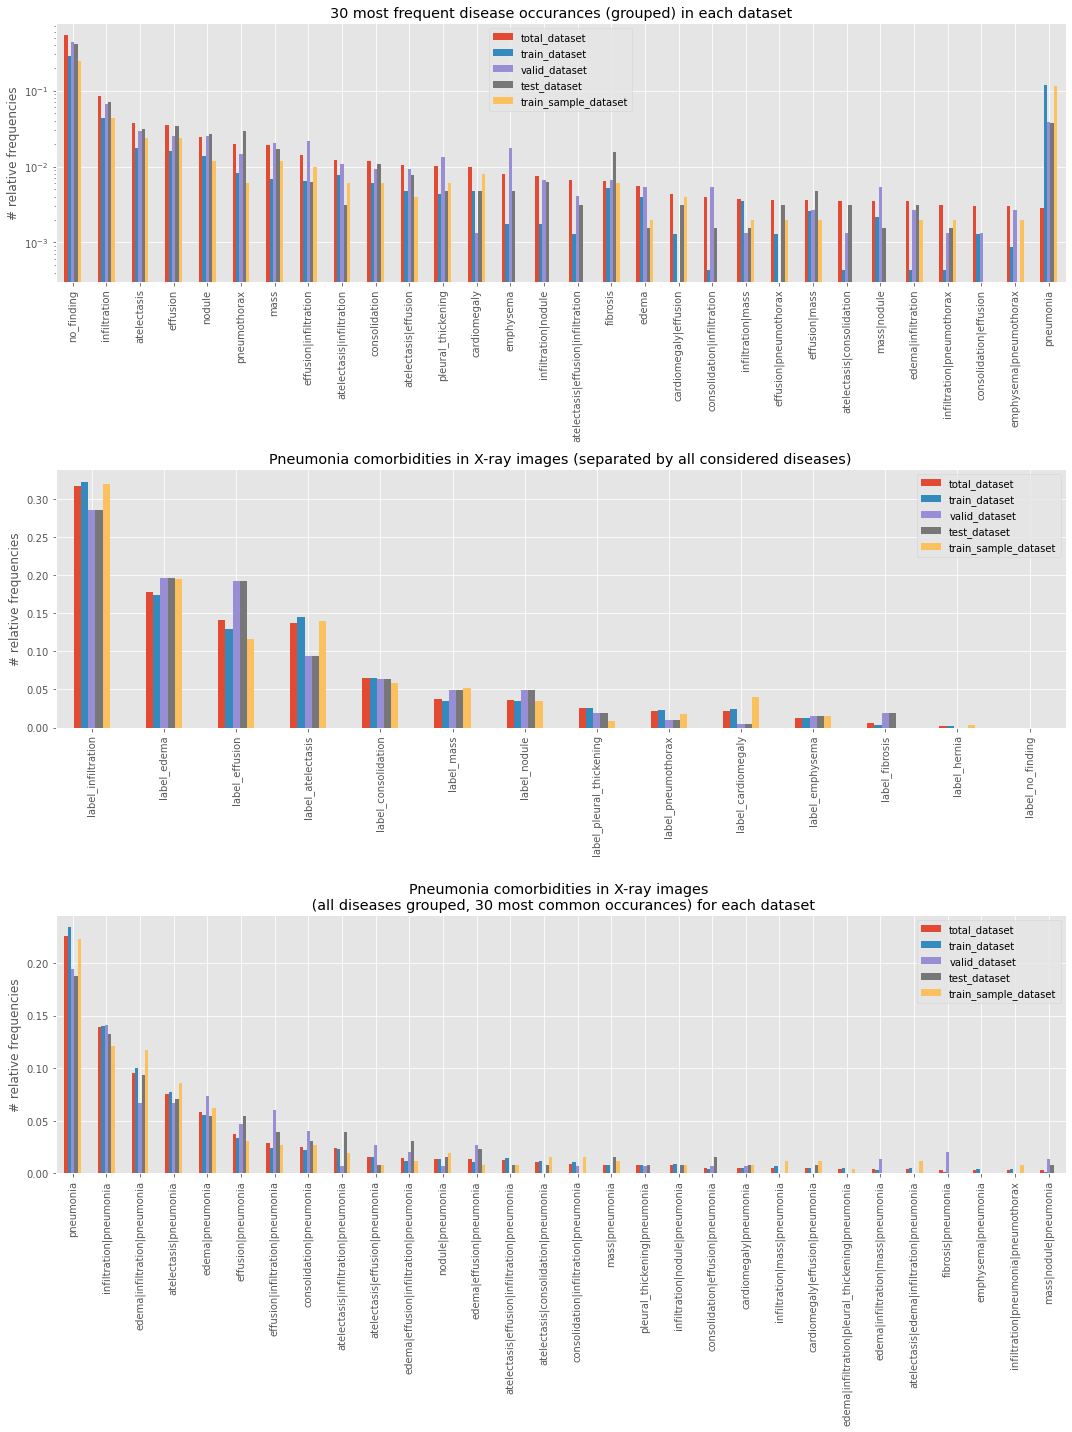

In [6]:
df_diseases = pd.DataFrame([])
df_diseases['total_dataset'] = df['finding_labels'].value_counts()
df_diseases['train_dataset'] = df_train['finding_labels'].value_counts()
df_diseases['valid_dataset'] = df_valid['finding_labels'].value_counts()
df_diseases['test_dataset'] = df_test['finding_labels'].value_counts()
df_diseases['train_sample_dataset'] = df_train_sample['finding_labels'].value_counts()
df_diseases_relative = df_diseases / df_diseases.sum()

dfa = pd.DataFrame([])
dfa['total_dataset'] = (
    df.loc[df['label_pneumonia']==1, df.columns.str.startswith('label')]
    .drop('label_pneumonia', axis=1)
    .sum()
    .sort_values(ascending=False)
)
dfa['train_dataset'] = (
    df_train.loc[df_train['label_pneumonia']==1, df_train.columns.str.startswith('label')]
    .drop('label_pneumonia', axis=1)
    .sum()
    .sort_values(ascending=False)
)
dfa['valid_dataset'] = (
    df_valid.loc[df_valid['label_pneumonia']==1, df_valid.columns.str.startswith('label')]
    .drop('label_pneumonia', axis=1)
    .sum()
    .sort_values(ascending=False)
)
dfa['test_dataset'] = (
    df_valid.loc[df_valid['label_pneumonia']==1, df_valid.columns.str.startswith('label')]
    .drop('label_pneumonia', axis=1)
    .sum()
    .sort_values(ascending=False)
)
dfa['train_sample_dataset'] = (
    df_train_sample.loc[df_train_sample['label_pneumonia']==1, df_train_sample.columns.str.startswith('label')]
    .drop('label_pneumonia', axis=1)
    .sum()
    .sort_values(ascending=False)
)

dfa_relative = dfa / dfa.sum()

df_coocurrance = pd.DataFrame([])
df_coocurrance['total_dataset'] = df.loc[df['finding_labels'].str.contains('pneumonia'),
                                         'finding_labels'].value_counts()
df_coocurrance['train_dataset'] = df_train.loc[df_train['finding_labels'].str.contains('pneumonia'),
                                               'finding_labels'].value_counts()
df_coocurrance['valid_dataset'] = df_valid.loc[df_valid['finding_labels'].str.contains('pneumonia'),
                                               'finding_labels'].value_counts()
df_coocurrance['test_dataset'] = df_test.loc[df_test['finding_labels'].str.contains('pneumonia'),
                                             'finding_labels'].value_counts()
df_coocurrance['train_sample_dataset'] = df_train_sample.loc[df_train_sample['finding_labels'].str.contains('pneumonia'),
                                                             'finding_labels'].value_counts()
df_coocurrance_relative = df_coocurrance / df_coocurrance.sum()


fig, axarr = plt.subplots(3, 1, figsize=(15, 20))
ttl = '30 most frequent disease occurances (grouped) in each dataset'
df_diseases_relative[:30].plot.bar(ax=axarr[0], title=ttl, label='b', logy=True)
axarr[0].set_ylabel('# relative frequencies')

ttl = 'Pneumonia comorbidities in X-ray images (separated by all considered diseases)'
dfa_relative.plot.bar(ax=axarr[1], title=ttl)
axarr[1].set_ylabel('# relative frequencies')

ttl = 'Pneumonia comorbidities in X-ray images \n (all diseases grouped, 30 most common occurances) for each dataset'
df_coocurrance_relative.head(30).plot.bar(ax=axarr[2], title=ttl)
axarr[2].set_ylabel('# relative frequencies')
fig.tight_layout()

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [7]:
# train_idg, val_idg, test_idg = image_augmentation(df_train_sample=df_train_sample, scale_type=SCALE_TYPE, **DICT_AUGMENTATION)
train_idg, val_idg, test_idg = preprocessing_image_data_generator(
    model_architecture=MODEL_BASE_ARCHITECTURE, **DICT_AUGMENTATION
)

print('Create training set generator:')
## Create actual generators using the output of image augmentation 
## (ImageDataGenerator()) for training data:
train_gen = train_idg.flow_from_dataframe(
    dataframe=df_train, 
    directory=None, 
    x_col='file_path',
    y_col='class_pneumonia',
    class_mode='binary',
    color_mode='rgb',
    weight_col=None,
    shuffle=True,
    seed=RANDOM_STATE,
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE_TRAIN,
    interpolation='nearest'
)
print('Create validation set generator:')
## Create actual generators using the output of image augmentation 
## (ImageDataGenerator()) for validation data:
## IMPORTANT: we may not shuffle the dataset because we want to match
## predictions to labels later (use val_gen.reset before each use of
## val_gen)
val_gen = val_idg.flow_from_dataframe(
    dataframe=df_valid, 
    directory=None, 
    x_col='file_path',
    y_col='class_pneumonia',
    class_mode='binary',
    color_mode='rgb',
    weight_col=None,
    shuffle=False,
    seed=None,
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE_VALID,
    interpolation='nearest'
)
print('Create testing set generator:')
## Create actual generators using the output of image augmentation 
## (ImageDataGenerator()) for validation data:
## IMPORTANT: we may not shuffle the dataset because we want to match
## predictions to labels later (use test_gen.reset before each use of
## test_gen)
test_gen = test_idg.flow_from_dataframe(
    dataframe=df_test, 
    directory=None, 
    x_col='file_path',
    y_col='class_pneumonia',
    class_mode='binary',
    color_mode='rgb',
    weight_col=None,
    shuffle=False,
    seed=None,
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE_TEST,
    interpolation='nearest'
)

Augmentation settings:
	- zca_whitening: False
	- horizontal_flip: True
	- vertical_flip: False
	- height_shift_range: 0.1
	- width_shift_range: 0.1
	- rotation_range: 10
	- shear_range: 0.1
	- zoom_range: 0.15
Create training set generator:
Found 2302 validated image filenames belonging to 2 classes.
Create validation set generator:
Found 745 validated image filenames belonging to 2 classes.
Create testing set generator:
Found 640 validated image filenames belonging to 2 classes.


In [8]:
## May want to pull a single large batch of random validation data for testing after each epoch:
# valX, valY = val_gen.next()

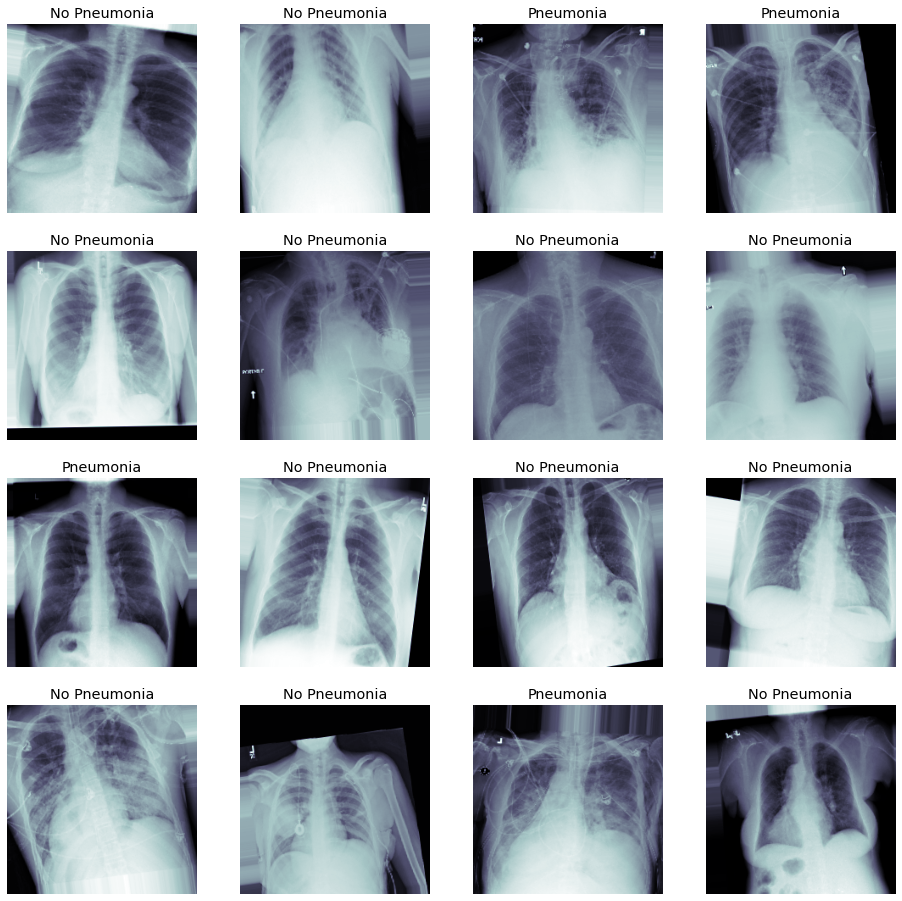

In [9]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [10]:
model_pretrained, last_conv_layer = load_pretrained_model(model_architecture=MODEL_BASE_ARCHITECTURE)
model = build_model(pretrained_model=model_pretrained)
model_pretrained.summary()

Trainable layers:
	conv5_block16_1_conv
	conv5_block16_1_bn
	conv5_block16_1_relu
	conv5_block16_2_conv
	conv5_block16_concat
	bn
	relu
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256 

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1

### Start training! 

In [12]:
%%time
## Set our optimizer, loss function, and learning rate
optimizer = keras.optimizers.Adam(
    lr=INITIAL_LEARNING_RATE, beta_1=0.9,
    beta_2=0.999
)
loss = 'binary_crossentropy'
metrics = [
    keras.metrics.BinaryAccuracy(name="binary_accuracy", threshold=0.5),
    keras.metrics.Precision(thresholds=0.5, name='precision'),
    keras.metrics.Recall(thresholds=0.5, name='recall'),
    keras.metrics.TruePositives(thresholds=0.5, name='tp'),
    keras.metrics.TrueNegatives(thresholds=0.5, name='tn'),
    keras.metrics.FalsePositives(thresholds=0.5, name='fp'),
    keras.metrics.FalseNegatives(thresholds=0.5, name='fn'),
    keras.metrics.AUC(name='auc')
]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


## add checkpoints to the model
## save 'best' version of model by comparing it to previous epochs of training

## monitor the validation loss metric to get the model's 'best' performance 
## The 'patience' parameter indicates how long the model will train without
## seeing improvement before quitting

dir_weights = f'{PATH_MODEL}weights/'
## create (sub-) directories if they do not exist:
os.makedirs(dir_weights, exist_ok=True)
## do not overwrite weights:
# path_weights = dir_weights + 'weights_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.hdf5'
## overwrite weights:
path_weights = f'{dir_weights}weights.hdf5'

cb_save_weights = keras.callbacks.ModelCheckpoint(
    filepath=path_weights, 
    monitor='val_loss',
    mode='min',
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True
)

# restore_best_weights: Whether to restore model weights from the epoch with the best
# value of the monitored quantity.
cb_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    patience=EARLY_STOPPING_PATIENCE,
    restore_best_weights=True
)

cb_reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.2,
    patience=5,
    min_lr=1e-7)

lst_callbacks = [cb_save_weights, cb_early_stopping, cb_reduce_lr]


## train model:
history = model.fit(
    x=train_gen,
    validation_data=val_gen,
    validation_freq=1,
    epochs=EPOCHS,
    callbacks=lst_callbacks,
    shuffle=True,
    steps_per_epoch=int(np.ceil(df_train.shape[0] / BATCH_SIZE_TRAIN)),
    validation_steps=int(np.ceil(df_valid.shape[0] / BATCH_SIZE_VALID))
)

Epoch 1/50
143/144 [============================>.] - ETA: 0s - loss: 1.0204 - binary_accuracy: 0.5389 - precision: 0.5409 - recall: 0.5362 - tp: 615.0000 - tn: 617.0000 - fp: 522.0000 - fn: 532.0000 - auc: 0.5498
Epoch 00001: val_loss improved from inf to 0.67408, saving model to models/model_resnet50_1/weights/weights.hdf5
144/144 [==============================] - 107s 744ms/step - loss: 1.0178 - binary_accuracy: 0.5400 - precision: 0.5428 - recall: 0.5376 - tp: 622.0000 - tn: 621.0000 - fp: 524.0000 - fn: 535.0000 - auc: 0.5504 - val_loss: 0.6741 - val_binary_accuracy: 0.5852 - val_precision: 0.2917 - val_recall: 0.7517 - val_tp: 112.0000 - val_tn: 324.0000 - val_fp: 272.0000 - val_fn: 37.0000 - val_auc: 0.6768 - lr: 0.0010
Epoch 2/50
144/144 [==============================] - ETA: 0s - loss: 0.7038 - binary_accuracy: 0.5821 - precision: 0.5785 - recall: 0.5967 - tp: 685.0000 - tn: 655.0000 - fp: 499.0000 - fn: 463.0000 - auc: 0.6177
Epoch 00002: val_loss did not improve from 0.674

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [13]:
## output final optimizer configs (e.g. learning rate)
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 8.000001e-06,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

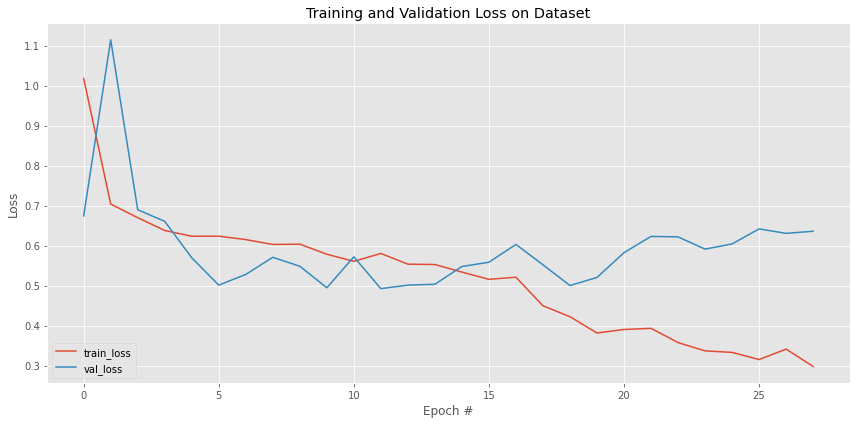

In [14]:
hst = plot_history(history=history)
plt.savefig(f'{PATH_FIGURES}train_valid_loss_progress.png', bbox_inches='tight')

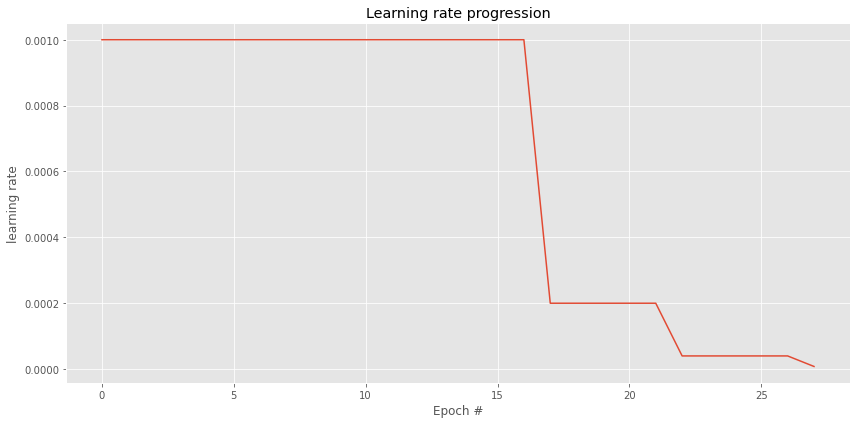

In [15]:
fig, ax = plt.subplots()
plt.plot(history.history['lr'])
ax.set_title("Learning rate progression")
ax.set_xlabel("Epoch #")
ax.set_ylabel("learning rate")
fig.tight_layout()

In [16]:
%%time
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model.load_weights(path_weights)

val_gen.reset()
y_pred_val = model.predict(val_gen, verbose=1, steps=int(np.ceil(df_valid.shape[0] / BATCH_SIZE_VALID)))

test_gen.reset()
y_pred_test = model.predict(test_gen, verbose=1, steps=int(np.ceil(df_test.shape[0] / BATCH_SIZE_TEST)))

40/40 [==============================] - 6s 152ms/step
CPU times: user 17.2 s, sys: 2.29 s, total: 19.5 s
Wall time: 16.3 s


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In this project our goal is to reduce the false negative (FN) predictions since this might lead to a loss of time for patients' treatments.
This means that we want to achieve a high recall since recall ~ 1/FN.
For measuring the performance of the model we chose the F1 metric for 2 reasons:
- The F1 metric is proportional to 1/FN (F1~1/FN). This means we have to maximize the F1 score to reduce the FN)
- We compare the performance of our model to the performance of four expert radiologists who achieved a F1 score of 0.387 (see https://arxiv.org/pdf/1711.05225.pdf)

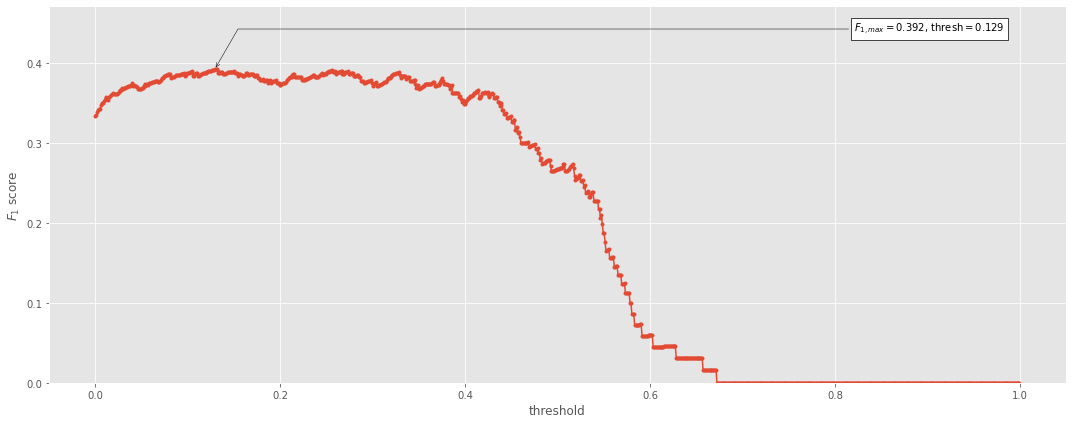

In [17]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# we compute the f1 score for several threshold values (both parameters operate in range [0, 1]) on the test set:

thresh_vals = np.arange(0, 1, .001)
f1_vals = []
for thresh in thresh_vals:
    f1_vals += [
        sklearn.metrics.f1_score(
            y_true=test_gen.labels,
            y_pred=get_classes(predictions=y_pred_test, thresh=thresh),
            labels=None,
            pos_label=1,
            average='binary',
            sample_weight=None,
            zero_division='warn'
        )
    ]
f1_vals = np.array(f1_vals)

def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= f"$F_{{1,max}}={ymax:.3f}$, thresh$=${xmax:.3f}"
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->", connectionstyle="angle, angleA=0, angleB=60", ec='k')
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)


fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(thresh_vals, f1_vals, '.-')
ax.set_xlabel('threshold')
ax.set_ylabel('$F_1$ score')
ax.set_ylim(0, f1_vals.max() * 1.2)
annot_max(x=thresh_vals,y=f1_vals, ax=ax)
fig.tight_layout()
plt.savefig(f'{PATH_FIGURES}f1_vs_threshold.png', bbox_inches='tight')

In [18]:
THRESH = thresh_vals[f1_vals.argmax()]

In [19]:
## get class predictions:
y_pred_classes_val = get_classes(predictions=y_pred_val, thresh=THRESH)
y_pred_classes_test = get_classes(predictions=y_pred_test, thresh=THRESH)

val_gen.reset
dict_evals_valid = evaluation_metrics(
    y_true=np.array(val_gen.labels).ravel(),
    y_pred=y_pred_classes_val.ravel(),
    y_pred_proba=y_pred_val.ravel()
)
test_gen.reset
dict_evals_test = evaluation_metrics(
    y_true=np.array(test_gen.labels).ravel(),
    y_pred=y_pred_classes_test.ravel(),
    y_pred_proba=y_pred_test.ravel()
)
print(f'validation evaluation metrics (threshold: {THRESH})')
_ = [print(f'\t{key}: {value}') for key, value in dict_evals_valid.items()]
print(f'test evaluation metrics (threshold: {THRESH})')
_ = [print(f'\t{key}: {value}') for key, value in dict_evals_test.items()]


validation evaluation metrics (threshold: 0.129)
	tp: 127
	tn: 270
	fn: 22
	fp: 326
	f1: 0.42192691029900337
	precision: 0.2803532008830022
	recall: 0.8523489932885906
	balanced_accuracy: 0.6526845637583892
	auc: 0.697468582496284
test evaluation metrics (threshold: 0.129)
	tp: 102
	tn: 222
	fn: 26
	fp: 290
	f1: 0.39230769230769236
	precision: 0.2602040816326531
	recall: 0.796875
	balanced_accuracy: 0.615234375
	auc: 0.6578369140625


### Plot validation metrics

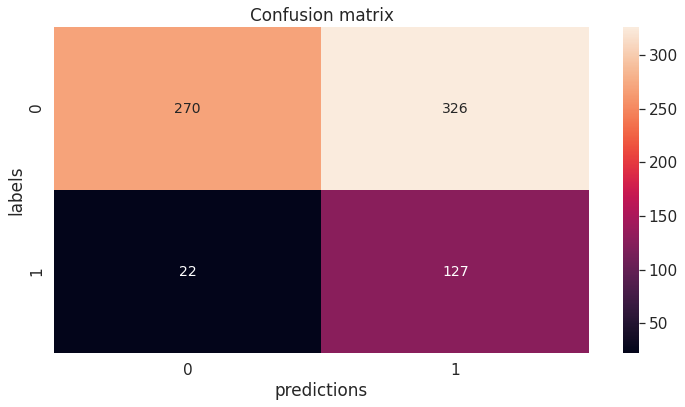

In [20]:
ax = plot_confusion_matrix(
    tp=dict_evals_valid['tp'], tn=dict_evals_valid['tn'],
    fp=dict_evals_valid['fp'], fn=dict_evals_valid['fn']
)
plt.savefig(f'{PATH_FIGURES}valid_confusion_matrix.png', bbox_inches='tight')

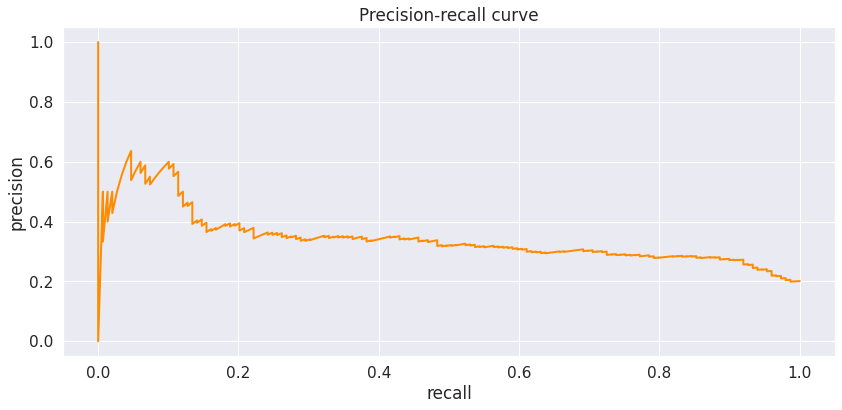

In [21]:
val_gen.reset
ax = plot_precision_recall_curve(
    y_true=np.array(val_gen.labels).ravel(),
    y_pred_proba=y_pred_val.ravel()
)
plt.savefig(f'{PATH_FIGURES}valid_precision_recall_curve.png', bbox_inches='tight')

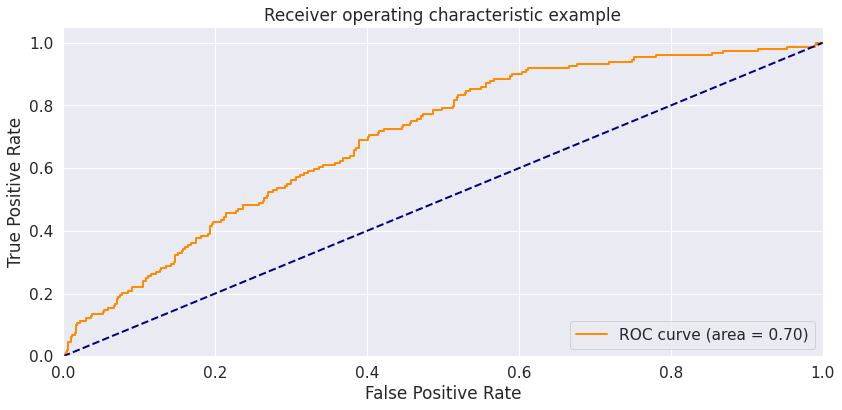

In [22]:
val_gen.reset
auc_ax, val_fpr, val_tpr = plot_auc(y_true=val_gen.labels, y_pred_proba=y_pred_val.ravel())
plt.savefig(f'{PATH_FIGURES}valid_roc_curve.png', bbox_inches='tight')

### Plot test metrics

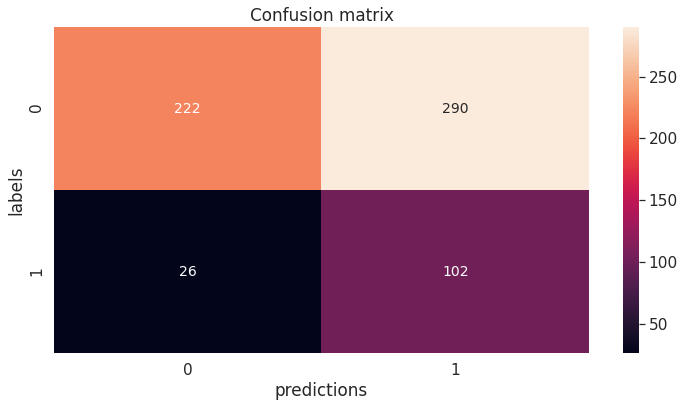

In [23]:
ax = plot_confusion_matrix(
    tp=dict_evals_test['tp'], tn=dict_evals_test['tn'],
    fp=dict_evals_test['fp'], fn=dict_evals_test['fn']
)
plt.savefig(f'{PATH_FIGURES}test_confusion_matrix.png', bbox_inches='tight')

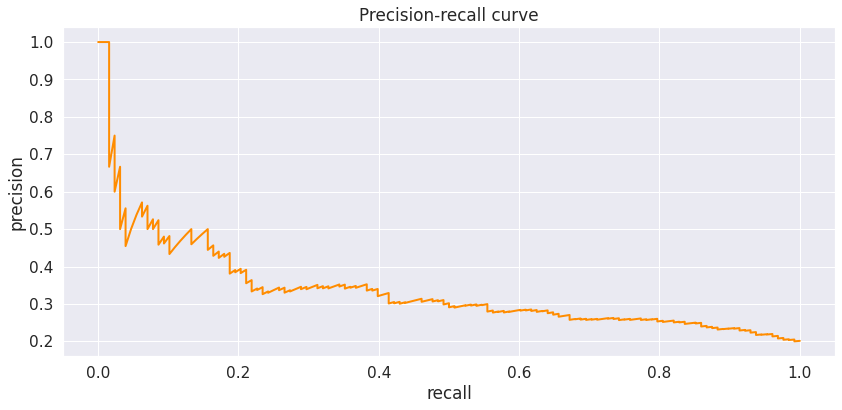

In [24]:
test_gen.reset
ax = plot_precision_recall_curve(
    y_true=np.array(test_gen.labels).ravel(),
    y_pred_proba=y_pred_test.ravel()
)
plt.savefig(f'{PATH_FIGURES}test_precision_recall_curve.png', bbox_inches='tight')

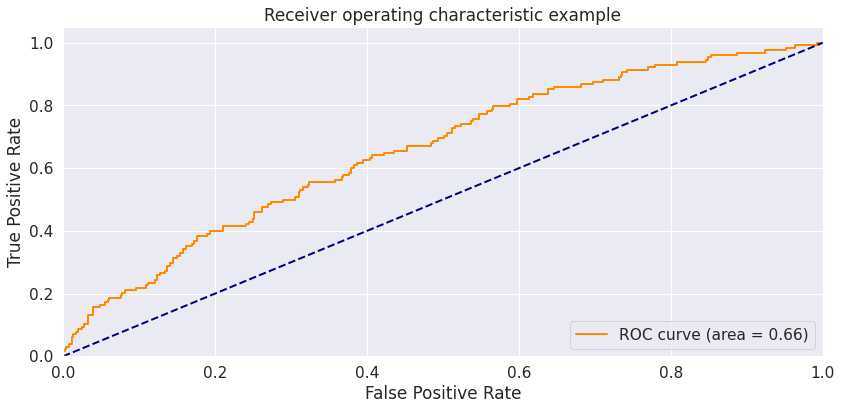

In [25]:
test_gen.reset
auc_ax, test_fpr, test_tpr = plot_auc(y_true=test_gen.labels, y_pred_proba=y_pred_test.ravel())
plt.savefig(f'{PATH_FIGURES}test_roc_curve.png', bbox_inches='tight')

In [26]:
# val_gen.reset()
# lst = model.evaluate_generator(generator=val_gen, verbose=1)

# test_gen.reset()
# model.evaluate_generator(generator=test_gen, verbose=1)

Validation data visualization:


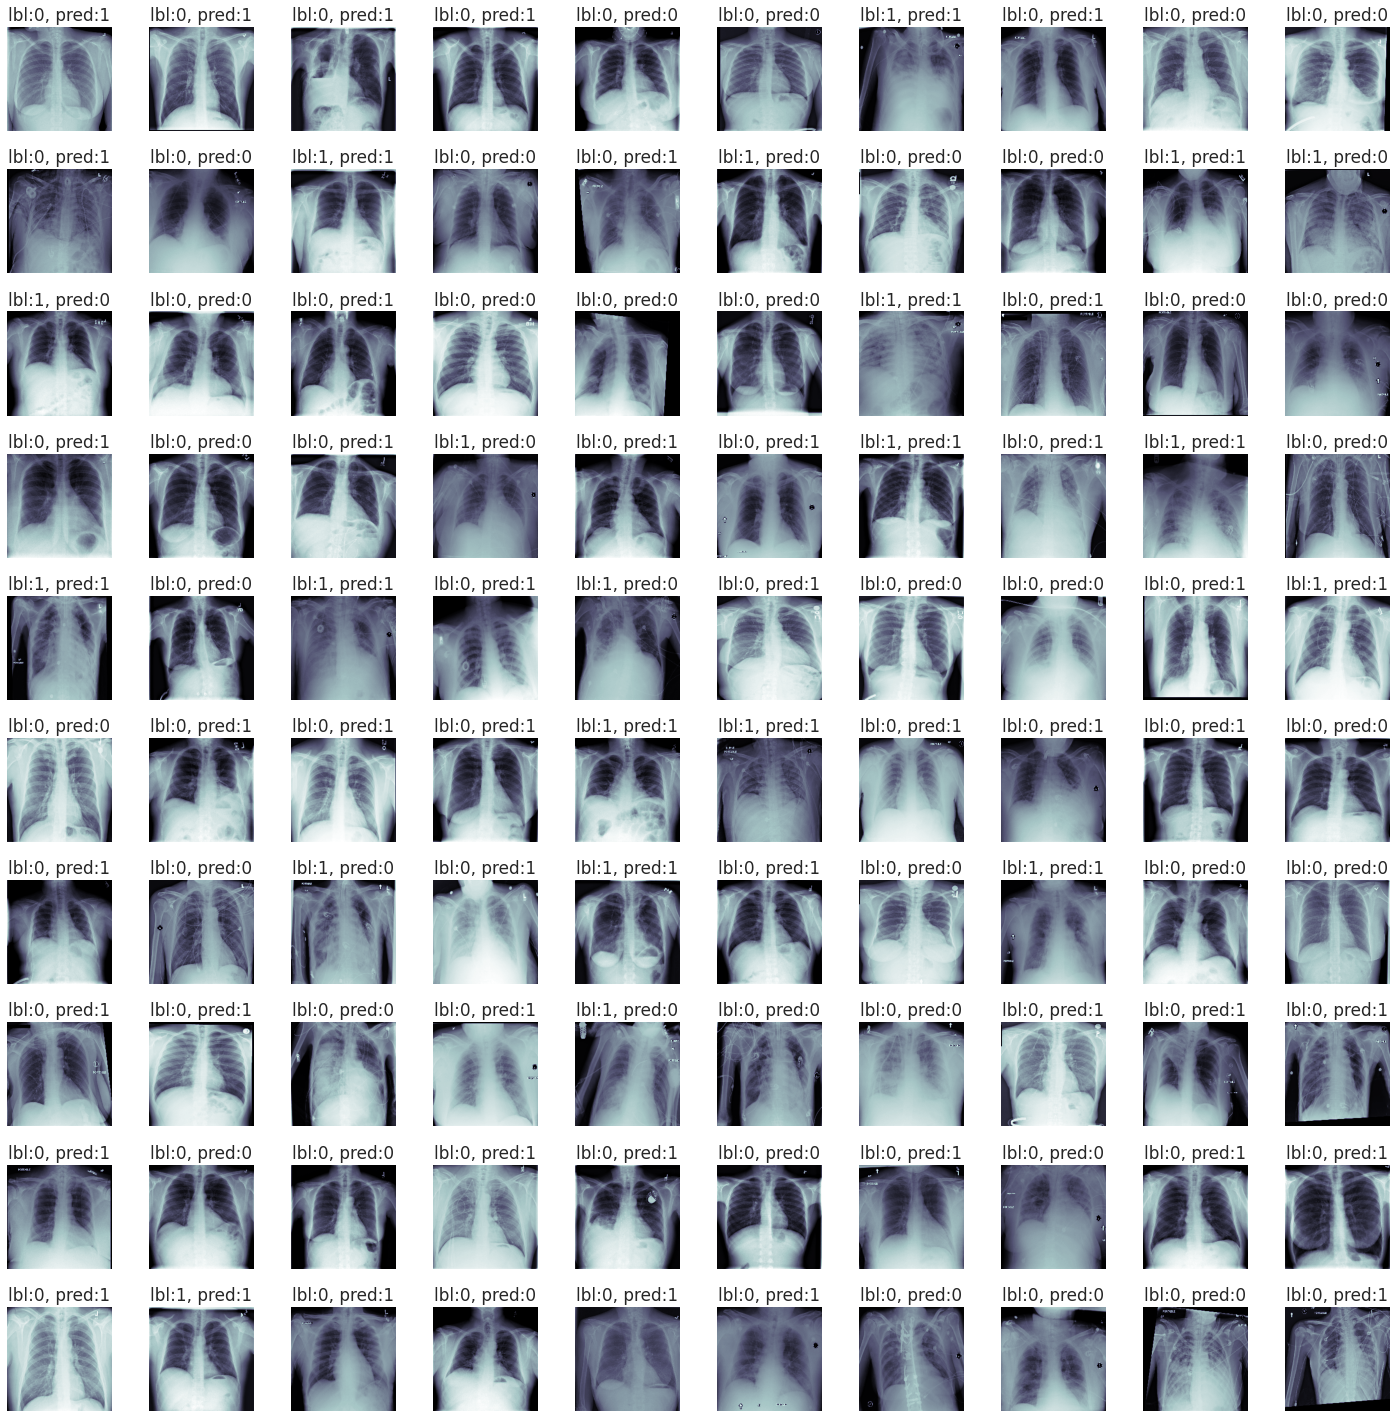

In [27]:
## Let's look at some examples of predicted v. true with our best model: 
print('Validation data visualization:')
val_gen.reset
val_labels = np.array([])
val_preds = []
while val_labels.size<100:
    gen = val_gen.next()
    val_labels = np.append(val_labels, gen[1])
    val_preds += [gen[0]]
val_preds = np.concatenate(val_preds, axis=0)

fig, m_axs = plt.subplots(10, 10, figsize = (20, 20))
i = 0
for (c_x, c_y, c_ax) in zip(val_preds[0:100], val_labels[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if y_pred_val[i] > THRESH:
            c_ax.set_title('lbl:1, pred:1')
        else:
            c_ax.set_title('lbl:1, pred:0')
    else:
        if y_pred_val[i] > THRESH: 
            c_ax.set_title('lbl:0, pred:1')
        else:
            c_ax.set_title('lbl:0, pred:0')
    c_ax.axis('off')
    i=i+1
fig.tight_layout()
plt.savefig(f'{PATH_FIGURES}validset_pneumonia_detection_vis.png', bbox_inches='tight')

Testing data visualization:


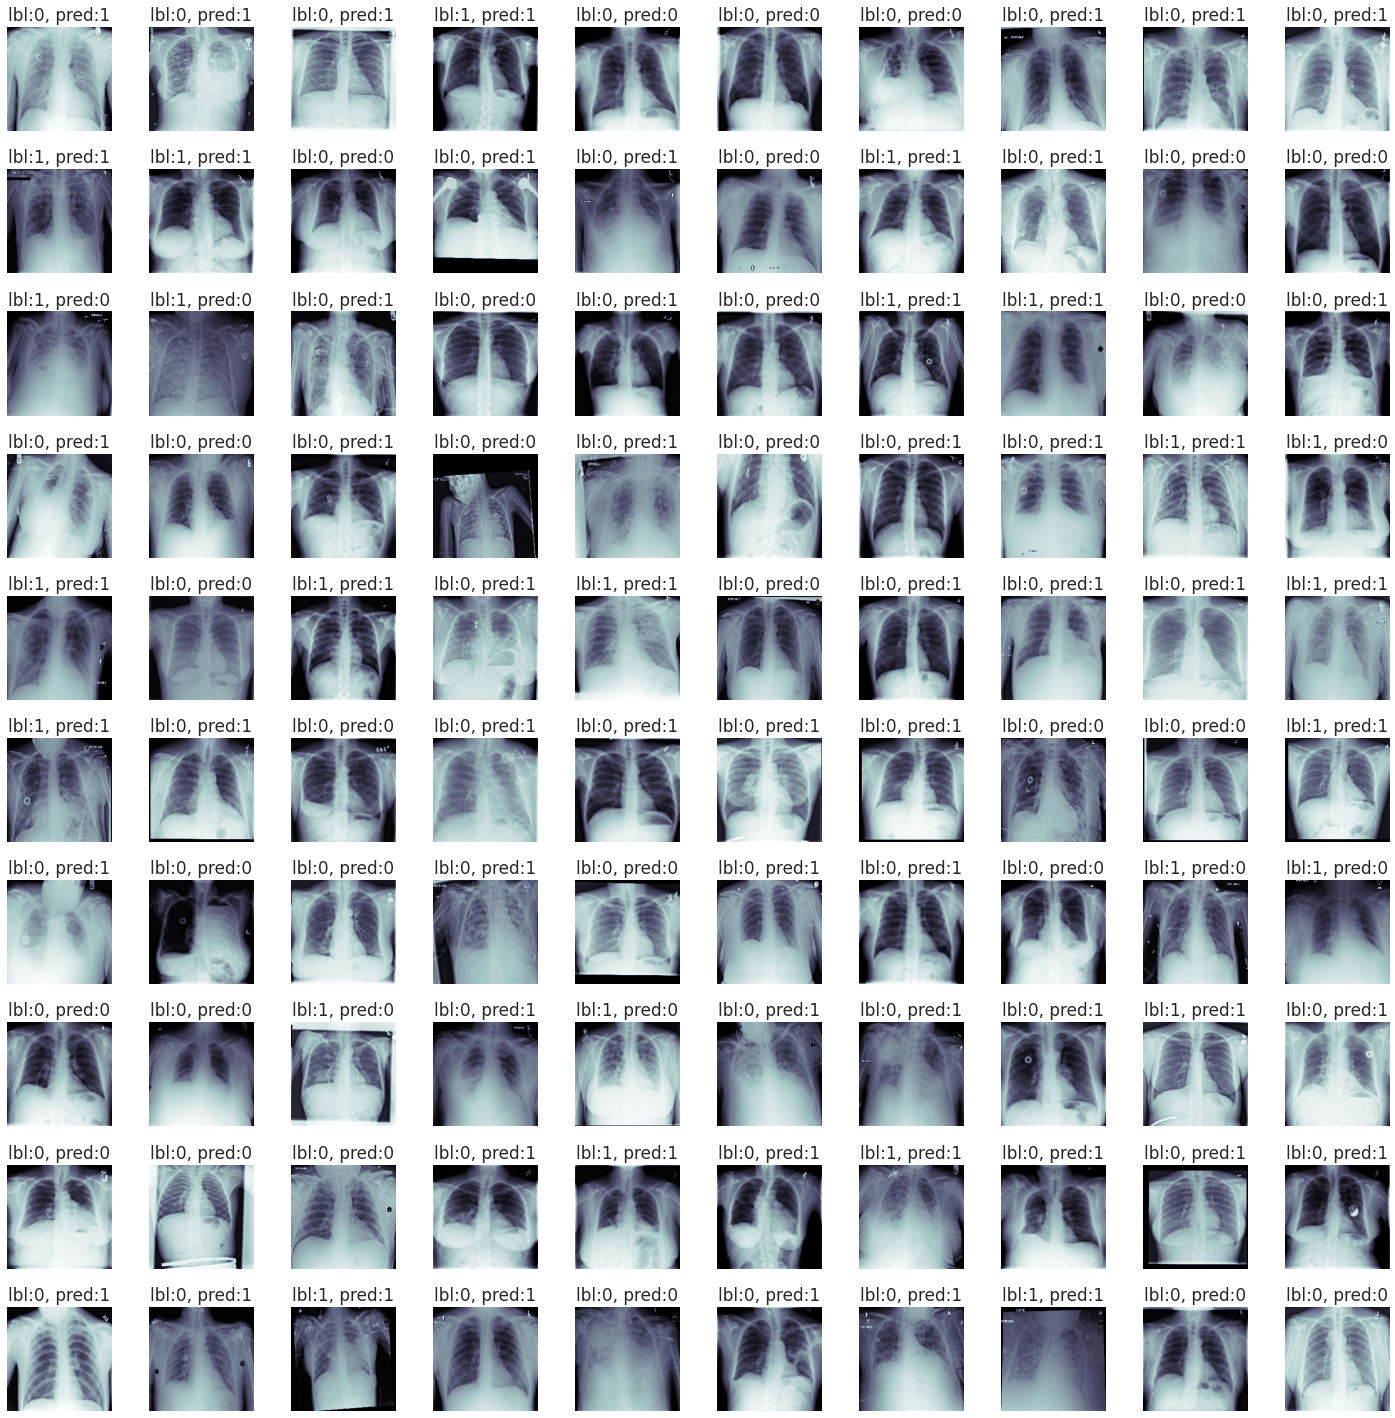

In [28]:
## Let's look at some examples of predicted v. true with our best model: 
print('Testing data visualization:')
test_gen.reset
test_labels = np.array([])
test_preds = []
while test_labels.size<100:
    gen = test_gen.next()
    test_labels = np.append(test_labels, gen[1])
    test_preds += [gen[0]]
test_preds = np.concatenate(test_preds, axis=0)

fig, m_axs = plt.subplots(10, 10, figsize = (20, 20))
i = 0
for (c_x, c_y, c_ax) in zip(test_preds[0:100], test_labels[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if y_pred_test[i] > THRESH:
            c_ax.set_title('lbl:1, pred:1')
        else:
            c_ax.set_title('lbl:1, pred:0')
    else:
        if y_pred_test[i] > THRESH: 
            c_ax.set_title('lbl:0, pred:1')
        else:
            c_ax.set_title('lbl:0, pred:0')
    c_ax.axis('off')
    i=i+1
fig.tight_layout()
plt.savefig(f'{PATH_FIGURES}testset_pneumonia_detection_vis.png', bbox_inches='tight')

In [29]:
hst = history.history
dict_evals = {
    'history': {key: np.array(value).tolist() for key, value in hst.items()},
    'valid_evaluation_stats': {key: float(value) for key, value in dict_evals_valid.items()},
    'test_evaluation_stats': {key: float(value) for key, value in dict_evals_test.items()},
    'valid_fpr': val_fpr.tolist(),
    'valid_tpr': val_tpr.tolist(),
    'test_fpr': test_fpr.tolist(),
    'test_tpr': test_tpr.tolist(),
}
with open(f'{PATH_MODEL}evaluation_metrics.yaml', 'w') as file:
    documents = yaml.dump(dict_evals, file)
    

## save model parameters:
dicts_configs = [
    {
        'MODEL_NAME': MODEL_NAME,
        'PATH_FIGURES': PATH_FIGURES,
        'PATH_MODEL': PATH_MODEL,
    },
    {    
        'RANDOM_STATE': RANDOM_STATE,
    },
    {
        'MODEL_BASE_ARCHITECTURE': MODEL_BASE_ARCHITECTURE,
        'IMG_SIZE': list(IMG_SIZE),
        'INITIAL_LEARNING_RATE': INITIAL_LEARNING_RATE,
        'EPOCHS': EPOCHS,
        'thresh': float(THRESH),
    },
    {
        'TRAIN_SIZE': TRAIN_SIZE,
        'VALIDATION_SIZE': VALIDATION_SIZE,
        'TEST_SIZE': TEST_SIZE,
        'BALANCE_TRAINING_DATA': BALANCE_TRAINING_DATA,
        'BATCH_SIZE_TRAIN': BATCH_SIZE_TRAIN,
        'BATCH_SIZE_VALID': BATCH_SIZE_VALID,
        'BATCH_SIZE_TEST': BATCH_SIZE_TEST,
        'DICT_AUGMENTATION': DICT_AUGMENTATION,
        'EARLY_STOPPING_PATIENCE': EARLY_STOPPING_PATIENCE,
    }
]

with open(f'{PATH_MODEL}config_parameters.yaml', 'w') as file:
    documents = yaml.dump(dicts_configs, file)

In [30]:
## save model:
# create directory and subdirectories if they do not exist:
# os.makedirs(PATH_MODEL, exist_ok=True)
# model.save(f'{PATH_MODEL}pneumonia_model', overwrite=True, include_optimizer=True)
# model.save(f'{PATH_MODEL}pneumonia_model.h5', overwrite=True, include_optimizer=True)
## save model architecture to a .json:
model_json = model.to_json()
with open(f'{PATH_MODEL}pneumonia_model.json', 'w') as json_file:
    json_file.write(model_json)